### Treatment Recommendation for CNS cases in Uganda

This dataset consists of the medical records of 480 children admitted to a hospital in Uganda with symptoms of a central nervous system (CNS) infection. The main causes of this type of infection in this region are malaria (treated with antimalarials) and bacterial menengitis (treated with antibiotics). In this particular study, the children were all put through extensive diagnostic tests, including a lumbar puncture, in order to reach a conclusive diagnosis and thus drive treatment. Even so, approximately half of the children did not end up with a final diagnosis.

The goal of this project is to train a machine classifier using clinical data that would be widely available in clinical settings in Uganda in order to recommend a course of treatment - antibiotics, antibacterials, both, or neither.

In [1]:
#Load necessary libraries
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import copy
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime
from collections import Counter
from matplotlib.pyplot import figure
import pickle

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Sci-bayes - built on top of scikit-learn, but includes Bayesian logistic regression
from skbayes.linear_models import EBLogisticRegression,VBLogisticRegression

In [2]:
#Subroutine for printing an array nicely
def print_array(a, cols, rows):
    if (len(cols) != a.shape[1]) or (len(rows) != a.shape[0]):
        print "Shapes do not match"
        return
    s = a.__repr__()
    s = s.split("array(")[1]
    s = s.replace("      ", "")
    s = s.replace("[[", " [")
    s = s.replace("]])", "]")
    pos = [i for i, ltr in enumerate(s.splitlines()[0]) if ltr == ","]
    pos[-1] = pos[-1]-1
    empty = " " * len(s.splitlines()[0])
    s = s.replace("],", "]")
    s = s.replace(",", "")
    lines = []
    for i, l in enumerate(s.splitlines()):
        lines.append(rows[i] + l)
    s  ="\n".join(lines)
    empty = list(empty)
    for i, p in enumerate(pos):
        empty[p-i] = cols[i]
    s = "".join(empty) + "\n" + s
    print s

In [3]:
#Load data set using pandas
data_raw = pd.read_csv("../Data/cns_data.csv") 
data_df = data_raw.copy() #hold onto an un-altered version just in case

In [4]:
#This function maps the raw data into usable variables - yes/no, mostly, although there is also a conversion of
#date to day of the year, in order to incorporate possible seasonality. All of the variables in this function would
#be available at clinical intake or shortly thereafter.
#
#Inputs: df - dataframe whose data needs to be mapped. params - list of parameters to be mapped.
#
def datamap(df,params):
    #Adjust some things that are always included and may need to be used:
    
    #df['dimain'] = df.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       #"Other":3})
    for label in params:
        #Mapping yes/no to 1/0
        if label =='date':
            df['incdate'] = pd.to_datetime(df['incdate'])
            df['date'] = (df['incdate'] - df['incdate'].min())  / np.timedelta64(1,'D')
        if label=='age':
            df['ageym'] = df.ageyrs.astype(float)*12.
            df['agemth'] = df.agemth.astype(float)
            df['age'] = df.ageym + df.agemth #total age in months
            #Mapping yes/no to 1/0
        if label=='clinjaund':
            df[label] = df.clinjaund.map({'Yes': 1, 'No': 0})
        if label=='clinhepato':
            df[label] = df.clinhepato.map({'Yes': 1, 'No': 0})
        if label=='clinspleno':
            df[label] = df.clinspleno.map({'Yes': 1, 'No': 0})
        if label=='clinconv':
            df['clinconv'] = df.clinconv.map({'Yes': 1, 'No': 0})
        if label=='clindehyd':
            df['clindehyd'] = df.clindehyd.map({'Yes': 1, 'No': 0})
        if label=='clinoedem':
            df['clinoedem'] = df.clinoedem.map({'Yes': 1, 'No': 0})
        if label=='clinlymph':
            df['clinlymph'] = df.clinlymph.map({'Yes': 1, 'No': 0})
        if label=='clinresp':
            df['clinresp'] = df.clinresp.map({'Yes': 1, 'No': 0})
        if label=='clinablung':    
            df['clinablung'] = df.clinablung.map({'Yes': 1, 'No': 0})
        if label=='clincyan':
            df['clincyan'] = df.clincyan.map({'Yes': 1, 'No': 0})
        if label=='clincapref':
            df['clincapref'] = df.clincapref.map({'Yes': 1, 'No': 0})
        if label=='clincoldext':
            df['clincoldext'] = df.clincoldext.map({'Yes': 1, 'No': 0})
        if label=='clinorcand':
            df['clinorcand'] = df.clinorcand.map({'Yes': 1, 'No': 0})
        if label=='clinhemmor':
            df['clinhemmor'] = df.clinhemmor.map({'Yes': 1, 'No': 0})
        if label=='clinaids':
            df['clinaids'] = df.clinaids.map({'Yes': 1, 'No': 0})
        if label=='vom':
            df['vom'] = df.vom.map({'Yes': 1, 'No': 0})
        if label=='diar':
            df['diar'] = df.diar.map({'Yes': 1, 'No': 0})
        if label=='headache':
            df['headache'] = df['head'] #Since 'head' is a function
            df['headache'] = df.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='conv':
            df['conv'] = df.conv.map({'Yes': 1, 'No': 0})
        if label=='age':
            df['ageym'] = df.ageyrs.astype(float)*12.
            df['agemth'] = df.agemth.astype(float)
            df['age'] = df.ageym + df.agemth #total age in months

        #Medical history variables
        if label=='mhhosp':
            df['mhhosp'] = df.mhhosp.map({'Yes': 1, 'No':0})

        #some slightly more compliated mappings
        if label=='abdpain':
            df['abdpain'] = df.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
        if label=='muscle':
            df['muscle'] = df.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
        if label=='mhdevsp':
            df['mhdevsp'] = df.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
                   'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
                   'SPEECH DEVELOPEMENTAL DELAY':1})
        #malaria rapid disagnositc
        if label=='malaria':
            df['malaria'] = df.malaria.map({'confirmed':2, 'no':0, 'probable':1})
            
        #outcome
        if label=='d3evol':
            df['d3evol'] = df.d3evol.map({'Gradual worsening':-1, 'Unchanged':0, 'Improved':1,\
                                          'Improved & worsened':-1})

        #Initial diagnosis coding: (either 'diagnosed - 0', or 'undiagnosed - 1')
        if label=='CMalaria':
            df['CMalaria'] = df.dimain.map({0:1,1:0,2:0,3:0})
        if label=='Enceph':
            df['Enceph'] = df.dimain.map({0:0,1:1,2:0,3:0})
        if label=='Mening':
            df['Mening'] = df.dimain.map({0:0,1:0,2:1,3:0})
        if label=='Other':
            df['Other'] = df.dimain.map({0:0,1:0,2:0,3:1})


        #This coding is going to be important. You'll want to figure out which categories are useful, and which
        #are practical.
        if label=='diag':
            df['diag'] = df.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                                'virus-bacteria':0, 'bacteremia':0,'bact meningitis':0,\
                                                'virus-other':0,'virus':0,'malaria-bacterial':0,\
                                                'tb':0,'crypto':0, '0.0':1})
        if label=='ttatb':
            df['ttatb'] = df.ttatb.map({'No':0,'Yes':1})
        if label=='ttmal':
            df['ttmal'] = df.ttmal.map({'No':0,'Yes':2})

In [5]:
#Select the patients who have improved. We are using this as an indicator of the 'right' treatment, although
#we know that this has limitations.
patients = data_df[data_df.d3evol=='Improved'].copy()
print 'There are', len(patients), 'patients who improved.'

#What parameters do we want to consider?
pmap = ['glasgtot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','headache','muscle','conv',\
                         'age','date',\
                         'temp','card','resp','sbp','dbp','weight','height',\
                         'malaria',
                         'mhhosp',\
               'ttatb','ttmal'] #These will be used to define the final treatment.

#Map all of these parameters to numerical values:
datamap(patients,pmap)

#Add the final category to the data - this is taken as the 'true' treatment.
patients['FinalTreatment'] = patients.ttmal+patients.ttatb #0 - none, 1 - atb, 2 - atm, 3 - both

There are 328 patients who improved.


In [6]:
#Define a function to train a Bayesian logistic regression model.
def trainVBLR(features,data,vblr,modelA,depth=0):
    features = np.array(features)
    Npar = len(features) - 1 #dimain and diag are always included in the list, but aren't model params
    XY_df = data.loc[:,features].dropna().copy()
    
    Input = XY_df.values
    X = Input[:,0:-1].copy()
    Y = Input[:,-1].copy()
    Y = Y.astype(float)
        
    #Map the three different models into model A vs. Other: 
    if modelA==1:    #antibiotics vs. other
        Y[Y==3.] = 2.
    if modelA==2:    #antimalarials vs. other
        Y[Y==1.] = 3.
    if modelA==3:    #both vs. other
        Y[Y==2.] = 1.
 
    
    print 'Number of patients in data set:', len(Y)
    print 'Number of features:', len(features)-1
    print 'Fitting model ...'
        
    vblr.__init__()
    vblr.fit(X,Y)    
    if depth<=1:  #If you're only fitting once
        return Input, features
        print 'model complete!'
    
    if depth>1:        #go through 'depth' number of times and drop all coefficients consistent with zero.
        depth -= 1
        covar_mat = copy.copy(vblr.sigma_)
        covar_mat = np.array(covar_mat)
        covar_mat = covar_mat.reshape([Npar+1,Npar+1])
        post_peaks = np.zeros([Npar])
        sigmas = np.zeros([Npar])
        for i in range(Npar):
            cval = vblr.coef_[0][i]
            post_peaks[i] = cval
            sigmas[i] = np.sqrt(covar_mat[i+1,i+1])

            post_peaks = np.array(post_peaks)  
            sigmas = np.array(sigmas)

            #Which are consistent (within 1 sigma) with zero?
            post_plus = post_peaks + 0.75*sigmas
            post_minus = post_peaks - 0.75*sigmas

            splus = np.sign(post_plus)
            sminus = np.sign(post_minus)

        keep = splus==sminus
        extra = [True]   #Need to hang onto the category label
        keep = np.concatenate([keep,extra])
        features = features[keep]
        print 'Non-zero Coefficients:',len(features)-1
        return trainVBLR(features,data,vblr,modelA,depth)
        depth = 0


In [7]:
#Train the vblr 
feature_list = ['glasgtot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','headache','muscle','conv',\
                         'age','date',\
                         'temp','card','resp','sbp','dbp','weight','height',\
                          'mhhosp', \
               'FinalTreatment']
vblr_both = VBLogisticRegression()
DataTrained, feat_kept_both = (trainVBLR(feature_list,patients,vblr_both,modelA=1,depth=3))
#You would need to do this three times to generate a predictive model for 'antimalarial vs other,' 'antibiotic vs.
#other,' and 'both vs. other' (none of the patients recieved no treatment)


Number of patients in data set: 180
Number of features: 32
Fitting model ...
nf 32 nsig 33
Non-zero Coefficients: 16
Number of patients in data set: 180
Number of features: 16
Fitting model ...
nf 16 nsig 17
Non-zero Coefficients: 16
Number of patients in data set: 180
Number of features: 16
Fitting model ...
nf 16 nsig 17


In [9]:
#The above was all about training the model to generate the 'machine learning' policy.
#Now, we actually generate the machine learning policy action for each patient:

#Load models and feature lists
modelList = pickle.load( open( "../Data/three_model_pickle.p", "rb" ) ) #You made these already - good for you!

pantb_model = modelList[0]
pantm_model = modelList[2]
pboth_model = modelList[4]

featAntb = list(modelList[1][:-1])
featAntm = list(modelList[3][:-1])
featBoth = list(modelList[5][:-1])

allFeat = featAntb + featAntm + featBoth
allFeat = list(set(allFeat))    #Collection of all of the features used - will want to test only on patients with
                                #non-NaN values for all of these.
allFeat.append('atatb')
allFeat.append('atmal')
allFeat.append('FinalTreatment')

finalPatients_df = patients[allFeat].copy()
finalPatients_df['atmal'] = finalPatients_df.atmal.map({'No':0,'Yes':1, np.nan:0})*2
finalPatients_df['atatb'] = finalPatients_df.atatb.map({'No':0,'Yes':1, 'Not applicable':0})
finalPatients_df = finalPatients_df.dropna()  #Only keep patients with values for all of these features.
finalPatients = finalPatients_df.values

Npatient = len(finalPatients)

#The features used are different for the three different models. We need patients with non-NaN values
#for all of these features.
print 'There are', Npatient, 'patients...'
print 'and', len(allFeat)-1, 'features.'

#Now, we go through and calculate the probability of each of the three treatments for each patient, and
#assign that patient to the category with the highest probability. 
#From the list of patients who have values for all possible features, select the features that were used in 
#each model:
atbFeatures = finalPatients_df[featAntb].values
atmFeatures = finalPatients_df[featAntm].values
bothFeatures = finalPatients_df[featBoth].values

TrueCat = finalPatients[:,-1]

#Generate the probabilities for each model:
pantb = pantb_model.predict_proba(atbFeatures)
pantm = pantm_model.predict_proba(atmFeatures)
pboth = pboth_model.predict_proba(bothFeatures)

Policy_ML = []
for i in range(Npatient):
    pvec = np.array([pantb[i,0]*100,pantm[i,0]*100,pboth[i,0]*100])
    Policy_ML.append(np.where(pvec==np.max(pvec))[0][0]+1)
Policy_ML = np.array(Policy_ML)
Policy_ML = Policy_ML.astype(float)

print allFeat

There are 180 patients...
and 27 features.
['clinhepato', 'conv', 'vom', 'resp', 'height', 'dbp', 'clinresp', 'weight', 'clinablung', 'clinconv', 'clinspleno', 'diar', 'headache', 'abdpain', 'malaria', 'card', 'clinlymph', 'clinoedem', 'glasgtot', 'temp', 'age', 'clinjaund', 'mhhosp', 'clindehyd', 'muscle', 'atatb', 'atmal', 'FinalTreatment']


In [10]:
#To see if this policy makes any improvements over what is already being done, we want to compare it to what 
#treatments are given at intake - i.e. before much clinical information is taken into account.
#Intake policy is just what was done directly on intake
Policy_In = finalPatients_df['atmal'] + finalPatients_df['atatb']
Policy_In = Policy_In.values
Policy_In = Policy_In.astype(float)
Policy_In[Policy_In==0.] = 4.

In [11]:
#Finally, what if we didn't do anything fancy at all and just gave every patient both treatments? We call this
# the 'kitchen sink' pollicy.
Policy_KS = np.ones(Npatient)*3.


In [12]:
#What everyone *should* have gotten
Truth = finalPatients_df['FinalTreatment'].values
Truth = Truth.astype(float)


In [13]:
#Now, go through and fill out the 'policy grid' for each of these three policies.
Pij_ML = np.zeros([4,4])
Pij_I = np.zeros([4,4])
Pij_KS = np.zeros([4,4])

poss = [1,2,3,4]
for i in poss:
    for j in poss:
        needmask = Truth==i
        
        gotmask = Policy_ML==j 
        Pij_ML[i-1,j-1] = sum(needmask*gotmask)
              
        gotmask = Policy_In==j
        Pij_I[i-1,j-1] = sum(needmask*gotmask)
        
        gotmask = Policy_KS==j
        Pij_KS[i-1,j-1] = sum(needmask*gotmask)
        

In [14]:
c = ["ab","am","b","n"]
r = ["atb ","atm ","both","none"]

ML_correct = Pij_ML[0,0]+Pij_ML[1,1]+Pij_ML[2,2]+Pij_ML[3,3]
I_correct = Pij_I[0,0]+Pij_I[1,1]+Pij_I[2,2]+Pij_I[3,3]
KS_correct = Pij_KS[0,0] + Pij_KS[1,1] + Pij_KS[2,2] + Pij_KS[3,3]

print "Machine Learning Policy:", float(ML_correct)*100./Npatient,"% accurate" 
print_array(Pij_ML,c,r)
print "\n"

print "Intake Policy:", float(I_correct)*100./Npatient,"% accurate" 
print_array(Pij_I,c,r)
print "\n"

print "Kitchen Sink Policy:", float(KS_correct)*100./Npatient,"% accurate" 
print_array(Pij_KS,c,r)
print "\n"

Machine Learning Policy: 66.6666666667 % accurate
     ab   am   b   n    
atb  [35.  0. 16.  0.]
atm  [ 0. 12.  8.  0.]
both [16. 20. 73.  0.]
none [ 0.  0.  0.  0.]


Intake Policy: 49.4444444444 % accurate
     ab   am   b   n    
atb  [21.  1.  1. 28.]
atm  [ 0. 11.  0.  9.]
both [ 7. 19. 57. 26.]
none [ 0.  0.  0.  0.]


Kitchen Sink Policy: 60.5555555556 % accurate
      ab    am    b    n    
atb  [  0.   0.  51.   0.]
atm  [  0.   0.  20.   0.]
both [  0.   0. 109.   0.]
none [  0.   0.   0.   0.]




We don't report on the precision and recall of the two methods here, because the consequences of mis-classifying a patient are different depending on the mis-classification. Undertreating is probably worse than overtreating. To assess the two different policies, then, we need to assign a cost to each possible combination of need/got.

Given that there are two possible drugs, lets just call them $A$ and $B$, (although those correspond in our case to antibiotics and antimalarials), each cell in the 'cost/action matrix' can be defined by four numbers.


$\begin{array}
 nn_A &= (0,1), \quad\quad \rm{need\,A?}\\   
 n_B &= (0,1), \quad\quad \rm{need\,B?}\\
 g_A &= (0,1), \quad\quad \rm{get\,A?}\\
 g_B &= (0,1), \quad\quad \rm{get\,B?}\\
\end{array}$

We can then define the cost of each of the cells, which are now uniquely defined by $(n_A,n_B,g_A,g_B)$, as:

$\rm{cost} = \left[\left\{n_Ag_A + n_Bg_B\right\} + f_1\times\left\{n_A(1-g_A)+n_B(1-g_B)\right\} + f_2\times\left\{(1-n_A)g_A+(1-n_B)g_B\right\}\right]\bigg/(n_A+n_B)$

The first term rewards the policy for giving drugs that were needed. The second term penalizes the policy for *not* giving drugs that *were* needed (missed treatment), and the third term penalizes the policy for *giving* drugs that were *not* needed (wasted treatment). The denominator scales the answer such that perfect treatment gives a return of 1. $f_1$ and $f_2$ scale the degree of the penalty accrued from missing or wasting treatment, respecitvely. As formulated, rewards and penalties for drug A and drug B are equal, but this could be adjusted.

In [15]:
#Loop through a grid of values in f1 and f2. 
nplot = 30
f1range = np.linspace(0.,10.,nplot)
f2range = np.linspace(0.,10.,nplot)

CmatI = np.zeros([nplot,nplot])
CmatML = np.zeros([nplot,nplot])
CmatKS = np.zeros([nplot,nplot])
BestP = np.zeros([nplot,nplot])

IntakeCats = Pij_I.flatten()
MLCats = Pij_ML.flatten()
KSCats = Pij_KS.flatten()

In [19]:
i = 0
for f1 in f1range:
    j = 0
    for f2 in f2range:
        C = np.array([1.,-(f1+f2),1.-f2,-f1,-(f1+f2),1.,1.-f2,-f1,(1.-f1)/2.,(1.-f1)/2.,1.,-f1,-f2,-f2,-2.*f2,1.])
        CmatI[i,j] = np.sum(IntakeCats*C)/Npatient
        CmatML[i,j] = np.sum(MLCats*C)/Npatient
        CmatKS[i,j] = np.sum(KSCats*C)/Npatient
        
        if np.max([CmatML[i,j],CmatI[i,j],CmatKS[i,j]])==CmatI[i,j]:
            BestP[i,j] = 0.
        elif np.max([CmatML[i,j],CmatI[i,j],CmatKS[i,j]])==CmatML[i,j]:
            BestP[i,j] = 1.
        elif np.max([CmatML[i,j],CmatI[i,j],CmatKS[i,j]])==CmatKS[i,j]:
            BestP[i,j] = 2.
        else:
            print 'Tie!', CmatI[i,j], CmatML[i,j],CmatKS[i,j]
            BestP[i,j] = 3.
        
        j += 1
    i += 1

Text(0.08,0.5,'care more about undertreating $\\longrightarrow$')

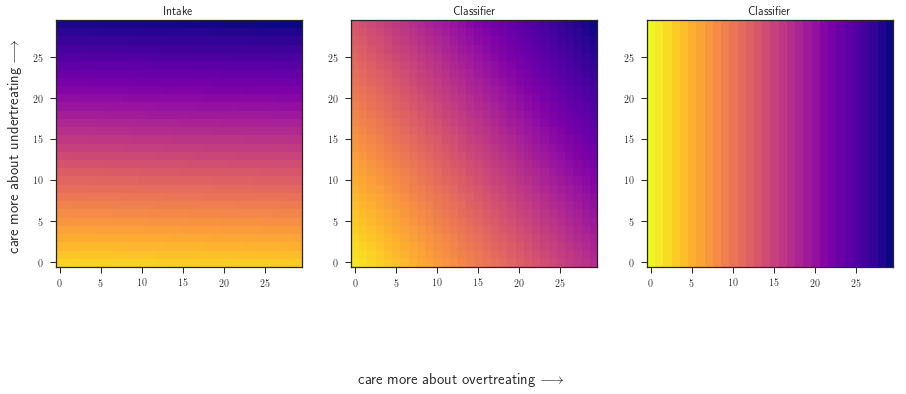

In [22]:
#f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,15))


ax3.imshow(CmatKS,cmap='plasma',vmax=1.)
ax3.set_title('Classifier')
ax2.imshow(CmatML,cmap='plasma',vmax=1.)
ax2.set_title('Classifier')
ax1.imshow(CmatI,cmap='plasma',vmax=1.)
ax1.set_title('Intake')

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

fig.text(0.5, 0.28, 'care more about overtreating $\longrightarrow$', ha='center',fontsize=15)
fig.text(0.08, 0.5, 'care more about undertreating $\longrightarrow$', va='center', rotation='vertical',fontsize=15)



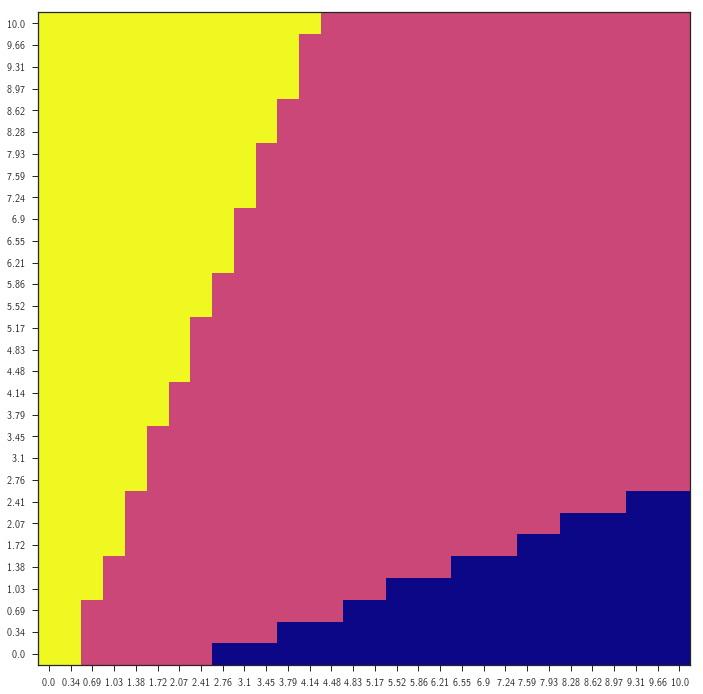

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
cax = ax.imshow(BestP, interpolation='none', cmap='plasma');
ax.set_xticks(np.arange(0,nplot,1));
ax.set_yticks(np.arange(0,nplot,1));
#ax.set_xticklabels(f2range,fontsize=12);
#ax.set_yticklabels(f1range,fontsize=12);
# get the current labels 
#labels = [item.get_text() for item in ax.get_xticklabels()]
# Beat them into submission and set them back again
ax.set_xticklabels([str(round(float(label), 2)) for label in f2range]);
ax.set_yticklabels([str(round(float(label), 2)) for label in f1range]);
plt.gca().invert_yaxis()
